# 1. Model 구현

In [96]:
from tensorflow.python.client import device_lib

In [97]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4204829862589688711
]


In [3]:
import cv2, numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
import keras
from keras import models, layers


def conv_3x3_relu(x, n):
    x = layers.Conv2D(n, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)

    return x



def Unet(a, b, c, d):
    # a = input_size
    # b = 처음에 몇 채널로 시작할지
    # c = output channel의 개수.
    # d = activation function

    input = layers.Input(a)


    #Encoder

    x = conv_3x3_relu(input, b)
    down1 = conv_3x3_relu(x, b)
    x = layers.MaxPool2D(pool_size=(2, 2))(down1)


    x = conv_3x3_relu(x, 2*b)
    down2 = conv_3x3_relu(x, 2*b)
    x = layers.MaxPool2D(pool_size=(2, 2))(down2)


    x = conv_3x3_relu(x, 4*b)
    down3 = conv_3x3_relu(x, 4*b)
    x = layers.MaxPool2D(pool_size=(2, 2))(down3)


    x = conv_3x3_relu(x, 8*b)
    down4 = conv_3x3_relu(x, 8*b)
    drop1 = layers.Dropout(0.3)(down4)
    x = layers.MaxPool2D(pool_size=(2, 2))(drop1)




    # Bottleneck

    x = conv_3x3_relu(x, 16*b)
    x = conv_3x3_relu(x, 16*b)
    drop2 = layers.Dropout(0.3)(x)




    # Decoder

    up1 = layers.Conv2DTranspose(8*b, (2, 2), strides=(2, 2))(drop2)
    merge1 = layers.concatenate([down4, up1], axis=3)
    x = conv_3x3_relu(merge1, 8*b)
    x = conv_3x3_relu(x, 8*b)
    x = conv_3x3_relu(x, 8*b)


    up2 = layers.Conv2DTranspose(4*b, (2, 2), strides=(2, 2))(x)
    merge2 = layers.concatenate([down3, up2], axis=3)
    x = conv_3x3_relu(merge2, 4*b)
    x = conv_3x3_relu(x, 4*b) 
    x = conv_3x3_relu(x, 4*b)


    up3 = layers.Conv2DTranspose(2*b, (2, 2), strides=(2, 2))(x)
    merge3 = layers.concatenate([down2, up3], axis=3)
    x = conv_3x3_relu(merge3, 2*b)
    x = conv_3x3_relu(x, 2*b) 
    x = conv_3x3_relu(x, 2*b)


    up4 = layers.Conv2DTranspose(b, (2, 2), strides=(2, 2))(x)
    merge4 = layers.concatenate([down1, up4], axis=3)
    x = conv_3x3_relu(merge4, b)
    x = conv_3x3_relu(x, b) 

    output = layers.Conv2D(c, (1, 1),name = 'result',activation = d)(x)

    Unet_model = models.Model(inputs=input, outputs=output)


    return Unet_model

In [5]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\GC\\anaconda3\\envs\\sangmin_env\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

---

```# a = input_size
    # b = 처음에 몇 채널로 시작할지
    # c = output channel의 개수.
    # d = activation function```

In [6]:
model = Unet((128, 128, 3), 32, 3, 'softmax')

In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# 2. Data load

In [8]:
import glob

data = glob.glob('.\\Data\\Chest CT Segmentation\\image\\image\\*.jpg')
label = glob.glob('.\\Data\\Chest CT Segmentation\\masks\\masks\\*.jpg')

In [9]:
print(len(data), len(label))

16708 16708


### 일치하지 않는 이미지가 있을 경우 찾아내기

In [10]:
"""train_data = []
train_label = []

for i in range(16708):
    if data[i][41:66] != label[i][41:66]:
        print(data[i])"""

'train_data = []\ntrain_label = []\n\nfor i in range(16708):\n    if data[i][41:66] != label[i][41:66]:\n        print(data[i])'

In [11]:
def get_img(fstr):
    """
    jpg, png등의 영상을 읽어들임.
    numpy ndarray형으로 읽어들임.
    """
    img = cv2.imread(fstr)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img/255.0
    #print(img.shape, img.dtype, np.max(img))
    return img

In [12]:
train_data = []
train_label = []

val_data = []
val_label = []

test_data = []
test_label = []


for i in range(8000):
    train_x = get_img(data[i])
    train_y = get_img(label[i])
    
    train_data.append(train_x)
    train_label.append(train_y)
    
    
for i in range(2000):
    val_x = get_img(data[i+5600])
    val_y = get_img(label[i+5600])
    
    val_data.append(val_x)
    val_label.append(val_y)
    

for i in range(1000):
    val_x = get_img(data[i+7000])
    val_y = get_img(label[i+7000])
    
    test_data.append(val_x)
    test_label.append(val_y)

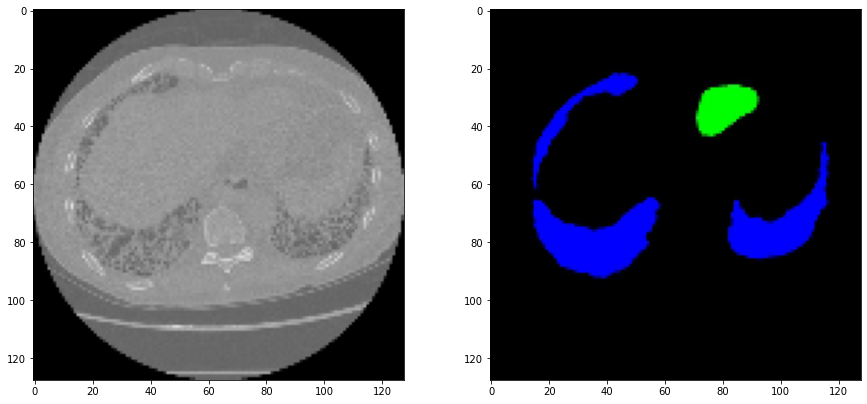

In [13]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.imshow(train_data[15])

plt.subplot(222)
plt.imshow(train_label[15])

In [14]:
np.max(train_label[200])

1.0

In [15]:
train_data = np.array(train_data)
train_label = np.array(train_label)

val_data = np.array(val_data)
val_label = np.array(val_label)

test_data = np.array(test_data)
test_label = np.array(test_label)


print(train_data.shape, train_label.shape, val_data.shape, val_label.shape, test_data.shape, test_label.shape, end='\n')

(8000, 128, 128, 3) (8000, 128, 128, 3) (2000, 128, 128, 3) (2000, 128, 128, 3) (1000, 128, 128, 3) (1000, 128, 128, 3)


In [16]:
#model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy, metrics='val_loss')
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())

In [17]:
history = model.fit(train_data, train_label, epochs = 100, batch_size = 100 ,validation_data = (val_data, val_label))

Epoch 1/100
80/80 [==============================] - 862s 11s/step - loss: 0.0230 - val_loss: 0.0842
Epoch 2/100
80/80 [==============================] - 891s 11s/step - loss: 0.0106 - val_loss: 0.0301
Epoch 3/100
80/80 [==============================] - 883s 11s/step - loss: 0.0072 - val_loss: 0.0294
Epoch 4/100
80/80 [==============================] - 869s 11s/step - loss: 0.0063 - val_loss: 0.0327
Epoch 5/100
80/80 [==============================] - 870s 11s/step - loss: 0.0059 - val_loss: 0.0291
Epoch 6/100
80/80 [==============================] - 873s 11s/step - loss: 0.0063 - val_loss: 0.0082
Epoch 7/100
80/80 [==============================] - 887s 11s/step - loss: 0.0057 - val_loss: 0.0089
Epoch 8/100
80/80 [==============================] - 874s 11s/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/100
80/80 [==============================] - 869s 11s/step - loss: 0.0053 - val_loss: 0.0053
Epoch 10/100
80/80 [==============================] - 866s 11s/step - loss: 0.0051 - val_lo

## Plot

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

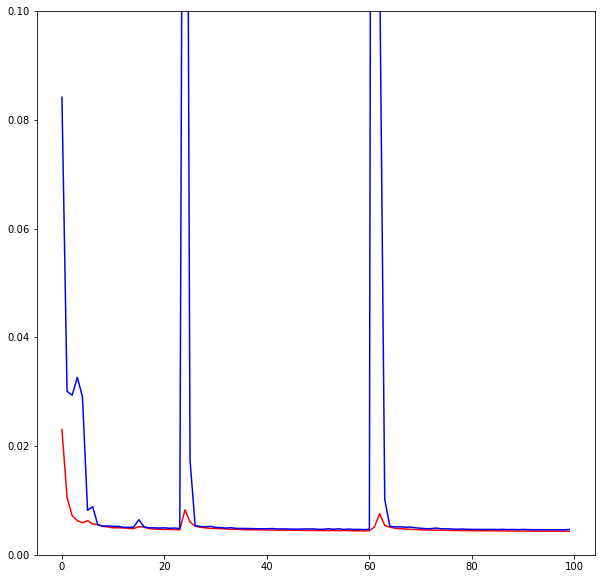

In [27]:
plt.figure(figsize = (10, 10))
plt.ylim((0, 0.1))

plt.plot(train_loss, 'r')
plt.plot(val_loss, 'b')

---   
# Test

In [90]:
test_data.shape

(1000, 128, 128, 3)

In [28]:
# test_data, test_label

predict_result = model.predict(test_data)

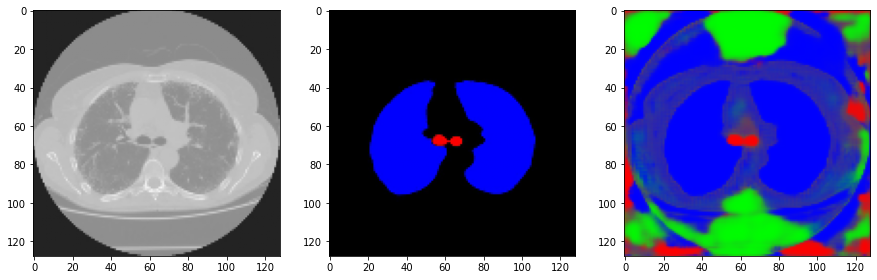

In [67]:
q = 500

plt.figure(figsize = (15, 15))

plt.subplot(231)
plt.imshow(test_data[q])

plt.subplot(232)
plt.imshow(test_label[q])

plt.subplot(233)
plt.imshow(predict_result[q])

---
## 0421 _ Mask MAKING

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


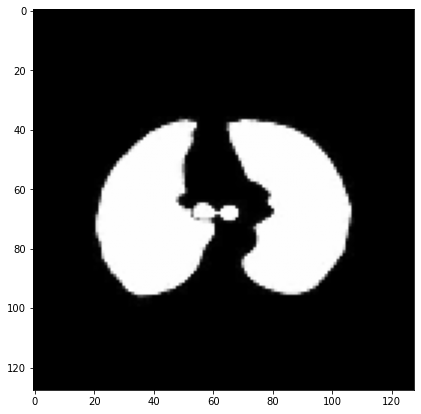

In [85]:
mask_1 = test_label[q][..., 0]
mask_2 = test_label[q][..., 1]
mask_3 = test_label[q][..., 2]

mask_final = mask_1 + mask_2 + mask_3
mask_final = np.stack((mask_final, mask_final, mask_final), axis = 2)

plt.figure(figsize = (7, 7))
plt.imshow(mask_final)

In [92]:
np.max(mask_final)

1.031372549019608

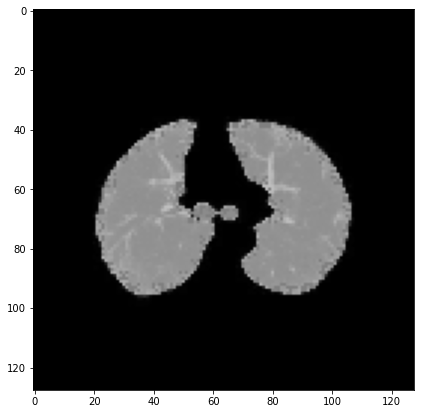

In [84]:
a = cv2.bitwise_and(test_data[q], mask_final)

plt.figure(figsize = (7, 7))
plt.imshow(a)

(1, 128, 128, 3)


TypeError: Invalid shape (1, 128, 128, 3) for image data

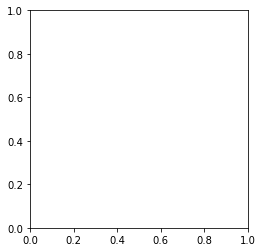

In [89]:
b = a[np.newaxis, ...]
print(b.shape)

c = model.predict(b)
plt.imshow(c)

---
## Model weight save

In [54]:
import datetime as dt

time_now = dt.datetime.now()
print(time_now.date())

2022-04-21


In [55]:
model.save('./weight/%s_model.h5' % time_now.date())